In [343]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline, PchipInterpolator
plt.close('all')

#Load Si photodioide responsivity data
SiResponse_data = np.loadtxt(r'Z:\Jacob\Correction Files\PDA36A2_Responsivity.txt')
Si_wl = SiResponse_data[:, 0]
Si_responsivity = SiResponse_data[:, 1]

#Load TiS laser output data
TiS_data = np.loadtxt(r'Z:\Jacob\Correction Files\TiS laser output measured by SiDiode.txt',skiprows=1)
TiS_wl = TiS_data[:, 0]
TiS_intensity = TiS_data[:, 1]

#Enter value to subtract dark counts
PMT_dark = 10772.4


def process_data(file_path):
    data = np.loadtxt(file_path, skiprows=10)

    t = data[:, 0]
    pmt = data[:, 1]
    w  = data[:, 3]
    intensity = data[:, 2]

    #This will trim the data if a large change in wavelength is found

    # Define a threshold for large change (e.g., 5)
    threshold = 5

    # Find the index where the large jump at the start stops
    start_index = 0
    for i in range(len(w) - 1):
        if abs(w[i + 1] - w[i]) >= threshold:
            start_index = i + 1
            if start_index > len(w)/2:
              start_index = 0
            break


    # Find the index where the large jump at the end begins
    end_index = len(w) - 1
    for i in range(len(w) - 2, -1, -1):
        if abs(w[i + 1] - w[i]) >= threshold:
            end_index = i + 1
            if end_index < len(w)/2:
              end_index = len(w)-1
            break


    # Ensure end_index is valid and does not overshoot


    # Slice the data to keep only the middle portion (after the start bad data and before the end bad data)
    t = t[start_index:end_index]
    w = w[start_index:end_index]
    intensity = intensity[start_index:end_index]
    #old_intensity = old_intensity[start_index:end_index]
    pmt = pmt[start_index:end_index]

    # Polynomial Fitting of wavelength
    #poly_fit_order_wavelength = 100 # change the order for nonlinear wavelength fitting
    #z = np.polyfit(t, w, poly_fit_order_wavelength)
    #p = np.poly1d(z)
    #fitted_wavelength = p(t)

    #Spline Fitting of wavelength
    # Tune smoothing factor until curve follows data well without overfitting
    spline_wavelength = UnivariateSpline(t, w, s=len(t)*0.01)
    fitted_wavelength = spline_wavelength(t)
    fitted_wavenumbers = 1e7 / fitted_wavelength  # cm^-1

    # Fit intensity to eliminate noise
    poly_fit_order_intensity = 10
    z2 = np.polyfit(t, intensity, poly_fit_order_intensity)
    p2 = np.poly1d(z2)
    fitted_intensity = p2(t)
    fitted_intensity = np.clip(fitted_intensity, a_min=0.00000000001, a_max=None)

    #Spline Fitting of intensity
    # Tune smoothing factor until curve follows data well without overfitting
    #spline_intensity = UnivariateSpline(t, intensity, s=len(t)*0.000000075)
    #fitted_intensity = spline_intensity(t)
    
    # Interpolate responsivity curve to data
    Si_responsivity_interpolated = np.interp(fitted_wavelength, Si_wl, Si_responsivity)

    # Interpolate TiS intensity curve to data
    #fitted_intensity = np.interp(fitted_wavelength, TiS_wl, TiS_intensity)

    ## Graph of Wavelength fitting
    plt.figure()
    plt.plot(t, w, label="Original Data")
    plt.plot(t, fitted_wavelength, label="Fitted model")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Wavelength (nm)")
    plt.title(f"Data vs curve fit for {os.path.basename(file_path)}")


    ## Graph of Intensity fitting
    plt.figure()
    plt.plot(t, intensity, label="Intensity Data")
    plt.plot(t, fitted_intensity, label="Fitted Line")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Laser Intensity (from spectrometer)")
    plt.title(f"Intensity Fitting for {os.path.basename(file_path)}")

    #subtract baseline and correct intensity
    scaled_pmt = ((pmt-PMT_dark) / fitted_intensity) / Si_responsivity_interpolated
    #scaled_pmt = ((pmt-np.min(pmt)) / fitted_intensity) / Si_responsivity_interpolated
    scaling_factor = np.mean(fitted_intensity)

    # --- Create sorted copies for output and final plot ---
    sort_idx = np.argsort(fitted_wavelength)
    sorted_wavelength = fitted_wavelength[sort_idx]
    sorted_scaled_pmt = scaled_pmt[sort_idx]
    # --- Convert to wavenumbers for final plot ---
    sorted_wavenumbers = 1e7 / sorted_wavelength  # cm^-1
    
    # --- Final PLE spectrum plot (sorted) ---
    plt.figure()
    plt.plot(sorted_wavenumbers, sorted_scaled_pmt * scaling_factor, label="Intensity Scaled Data (sorted)")
    plt.plot(fitted_wavenumbers, pmt, label="Original Data (scan order)")
    plt.xlabel("Wavenumbers (cm^{-1}$))")
    plt.ylabel("Intensity (a.u)")
    plt.legend()
    plt.title(f"PLE Spectrum for {os.path.basename(file_path)}")
    plt.show()

    # --- Return both unsorted and sorted versions ---
    return (
        t,
        fitted_wavelength,  # original scan order
        fitted_intensity,
        scaled_pmt,         # original scan order
        pmt,
        scaling_factor,
        sorted_wavelength,  #sorted by wavelength
        sorted_scaled_pmt,   #scaled_pmt sorted to match
        sorted_wavenumbers
    )

In [364]:
data_directory = r'Z:\Jacob\Material CrPS4\Undoped\07302025 PLE Trap highE Peak\PMTPLE\Laser\VTPLE'
save_directory = r'Z:\Jacob\Material CrPS4\Undoped\07302025 PLE Trap highE Peak\PMTPLE\Laser\VTPLE'

# Create a subfolder for saving the processed files
subfolder = os.path.join(save_directory, 'processed_PLE_files')

# Check if the subfolder exists; if not, create it
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

In [366]:
data_files = [
    f for f in os.listdir(data_directory)
    if os.path.isfile(os.path.join(data_directory, f))  # Skip subfolders
    #and len(np.loadtxt(os.path.join(data_directory, f), skiprows=10).T) == 5
    #This selects all files in current folder, or...
    # Add other file names here
    ]

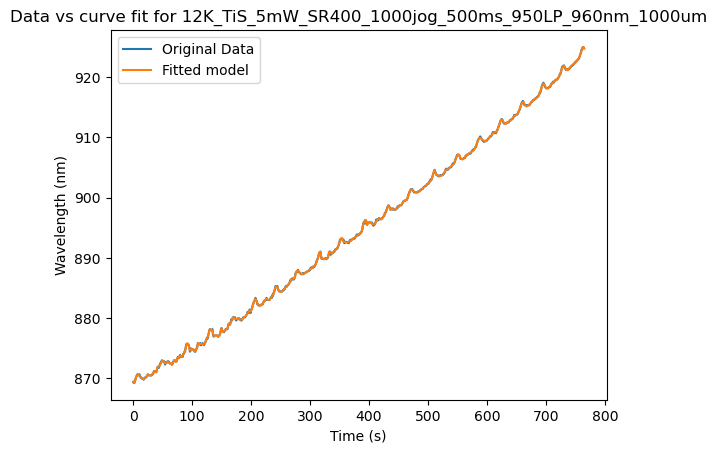

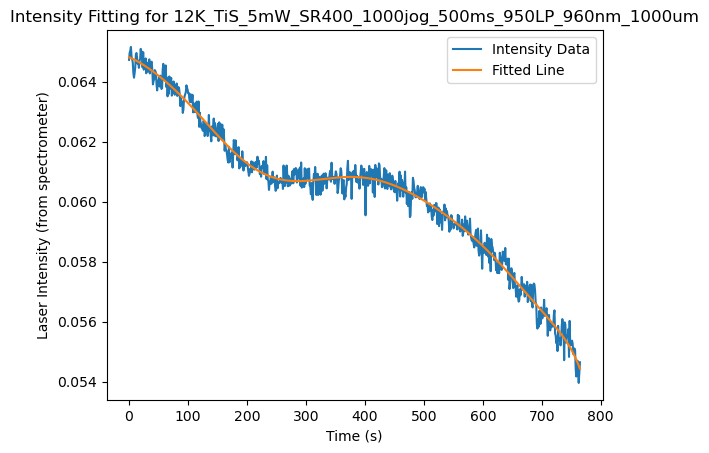

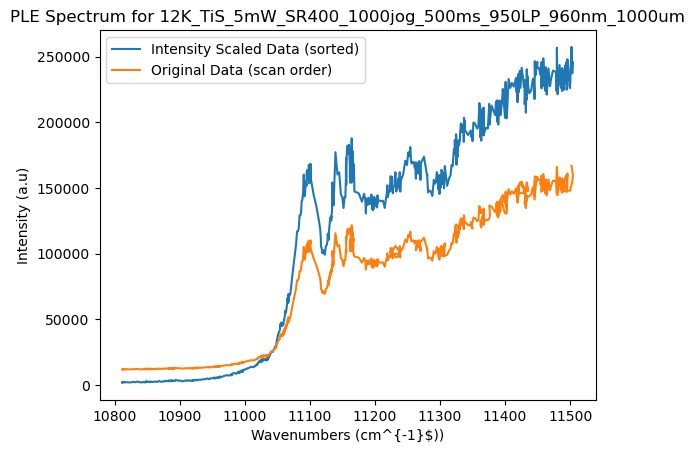

Processed and saved: 12K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


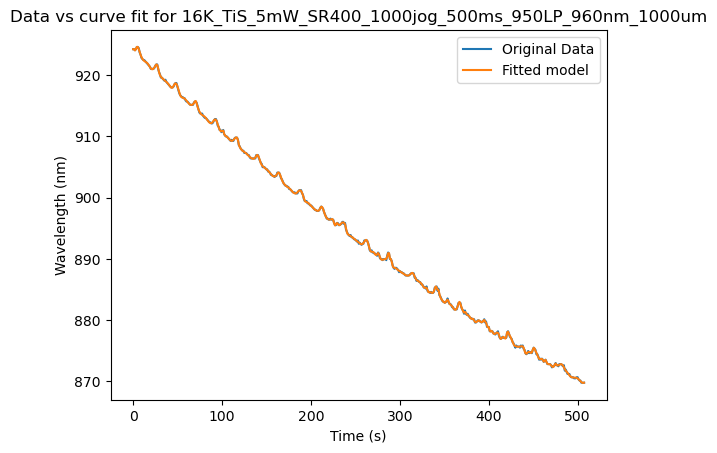

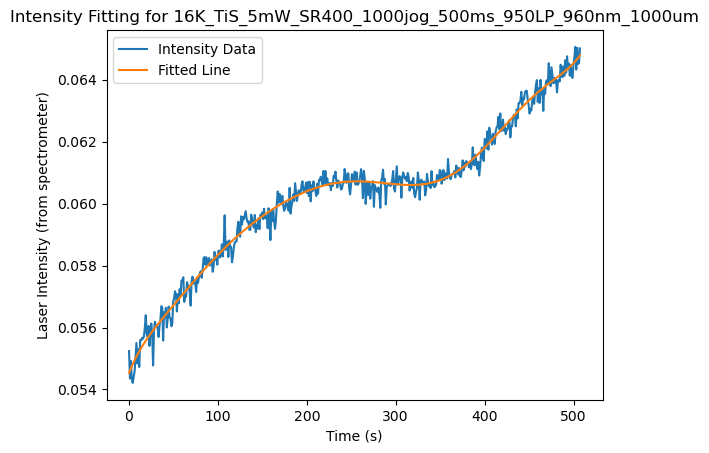

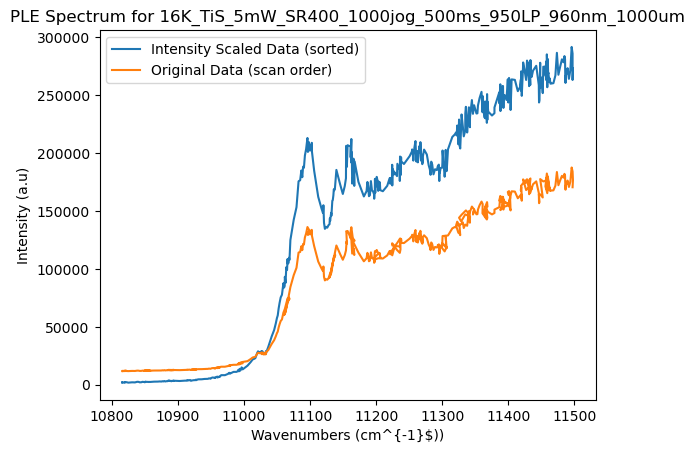

Processed and saved: 16K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


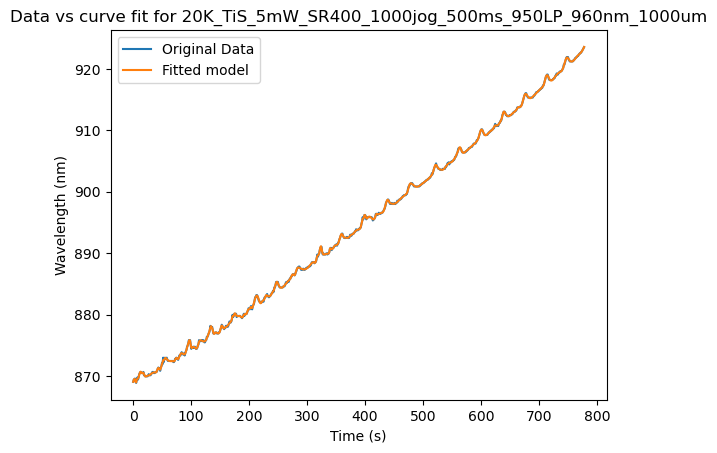

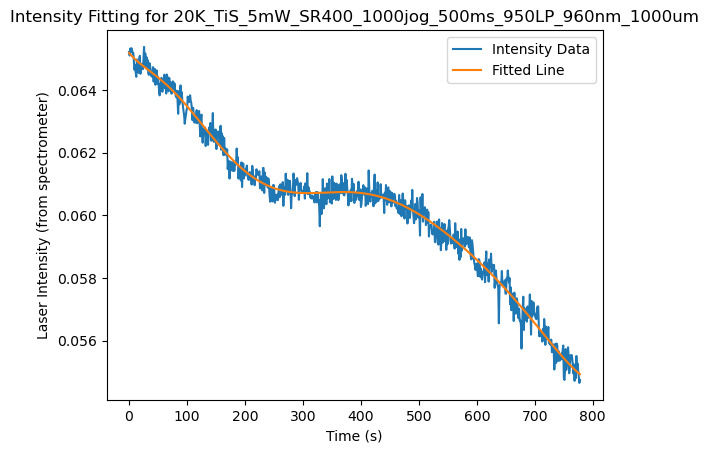

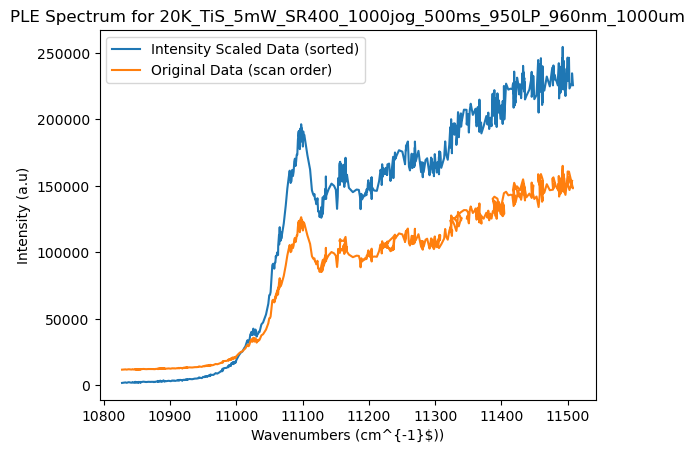

Processed and saved: 20K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


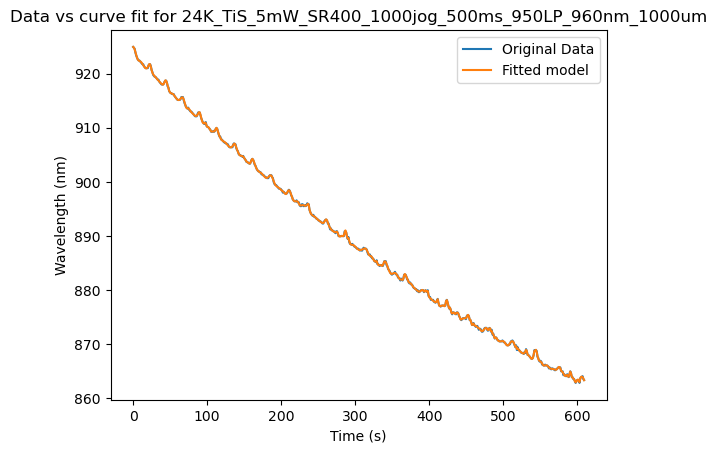

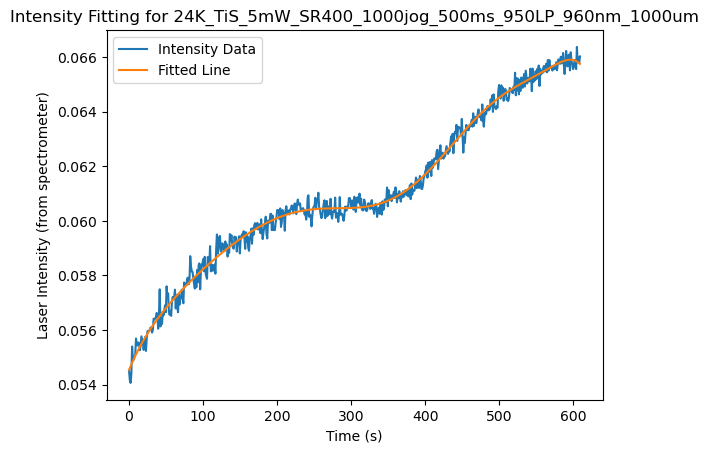

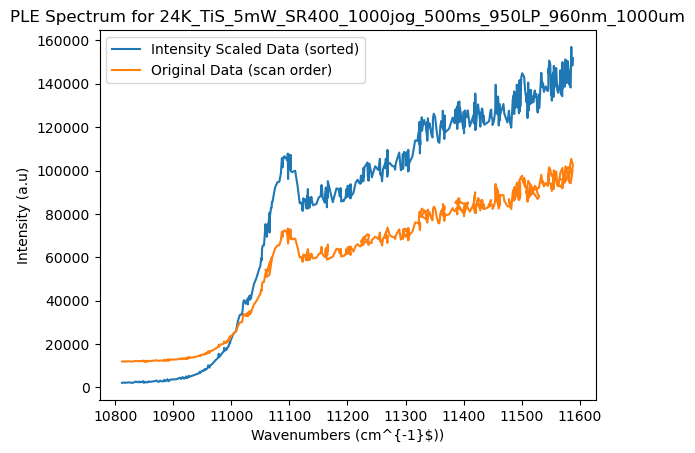

Processed and saved: 24K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


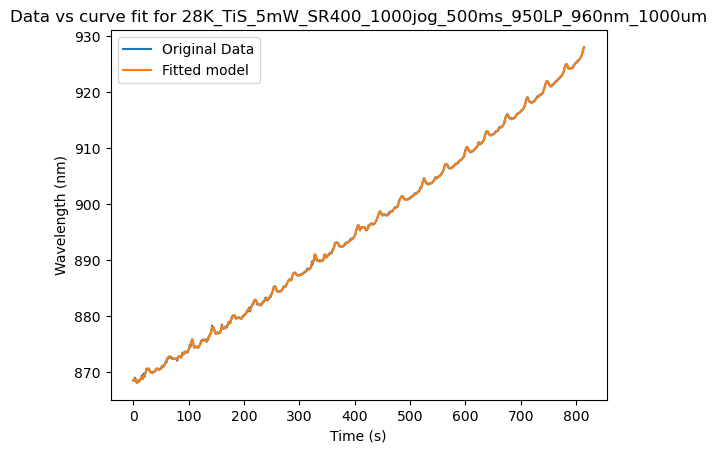

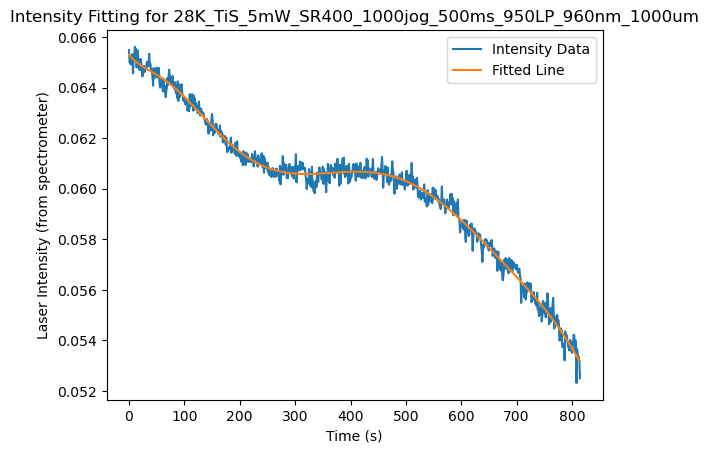

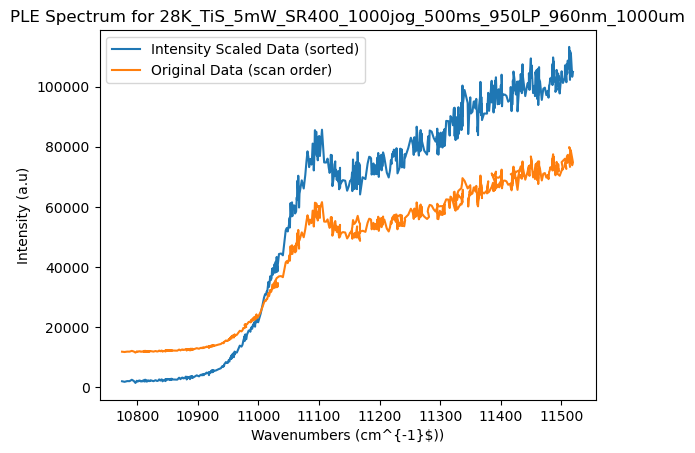

Processed and saved: 28K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


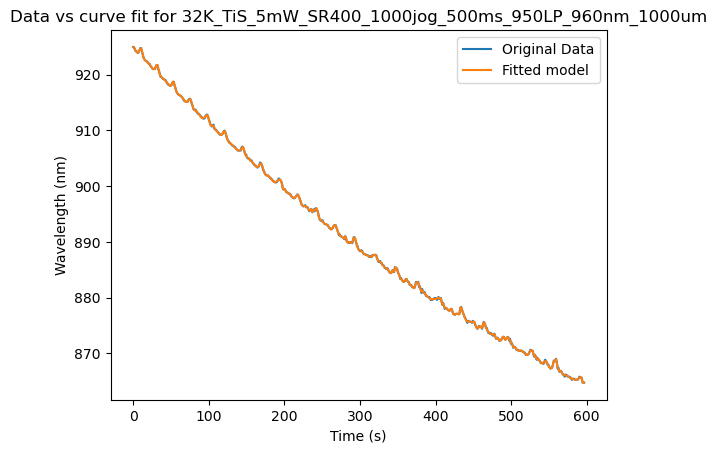

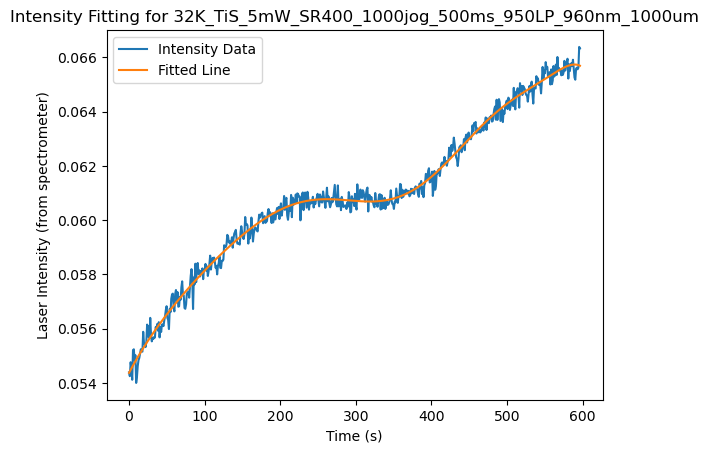

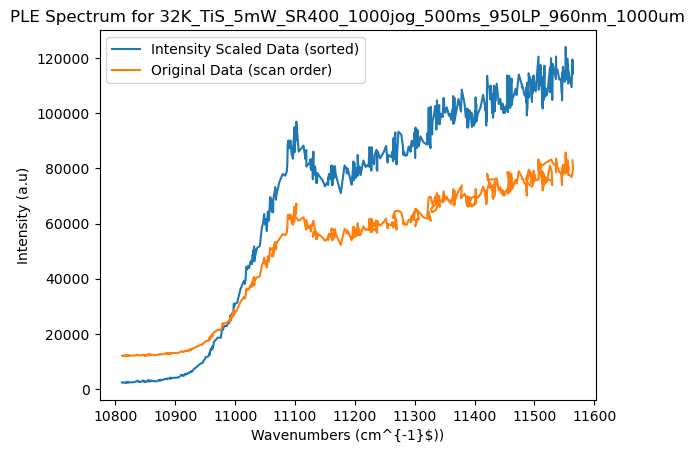

Processed and saved: 32K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


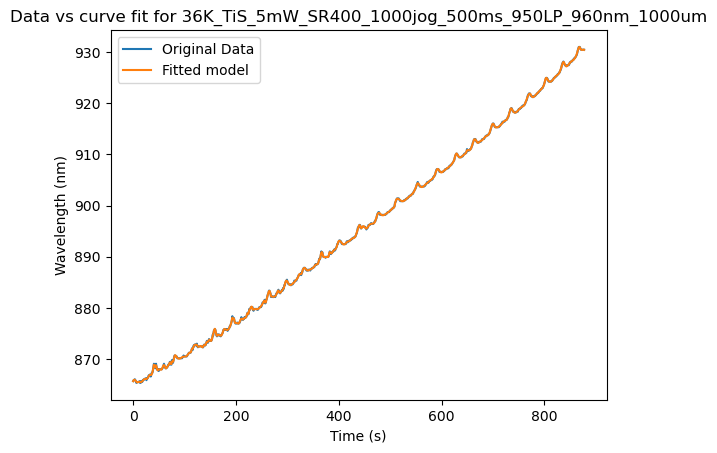

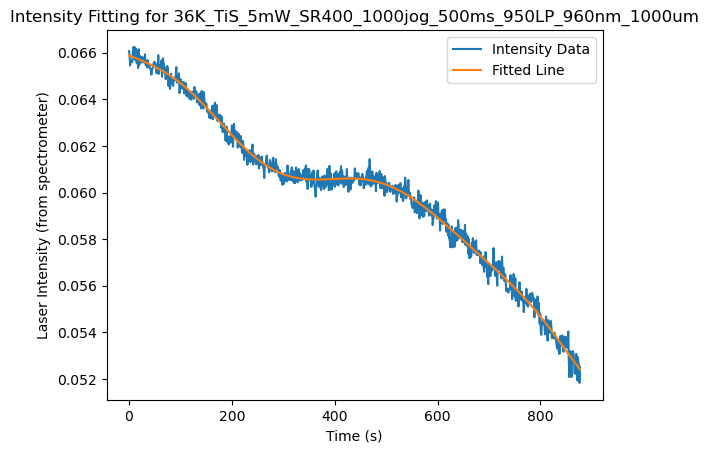

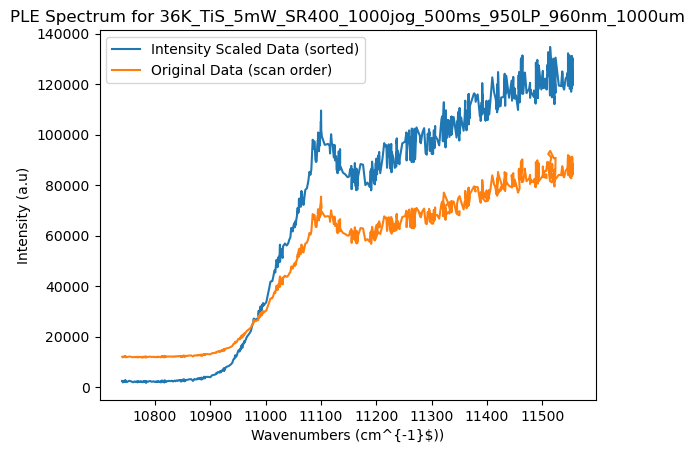

Processed and saved: 36K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


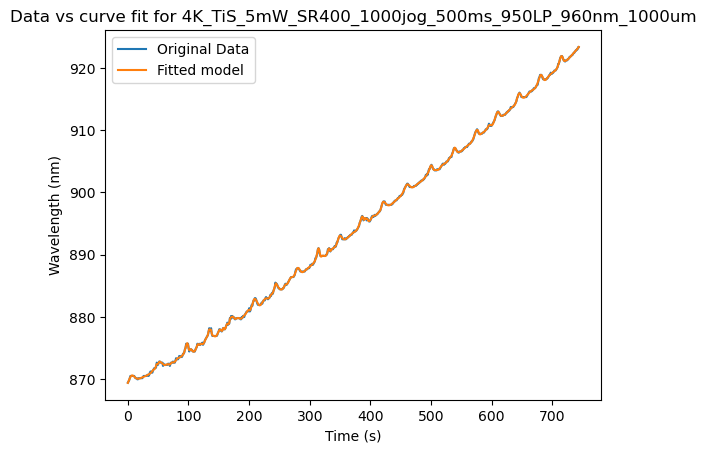

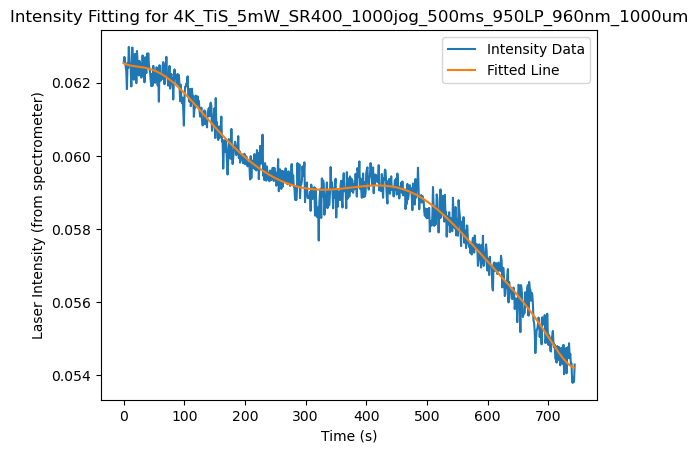

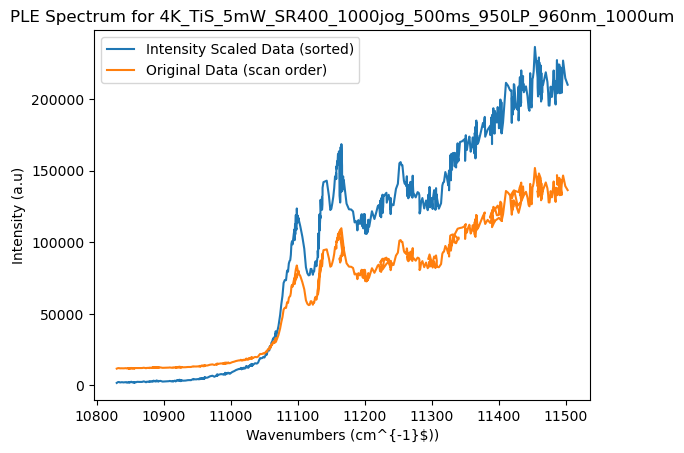

Processed and saved: 4K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


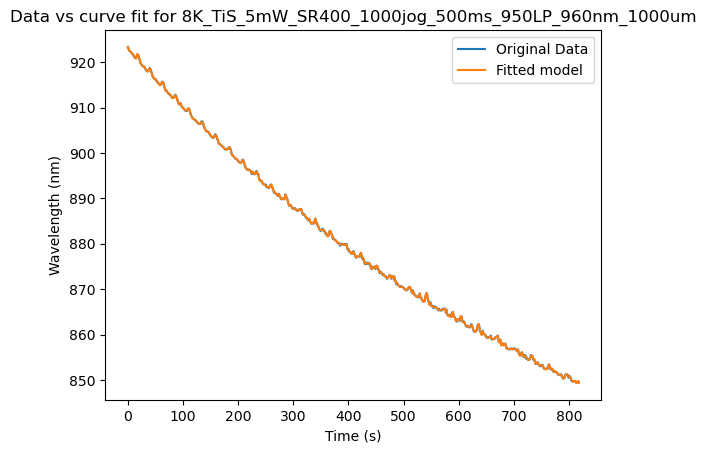

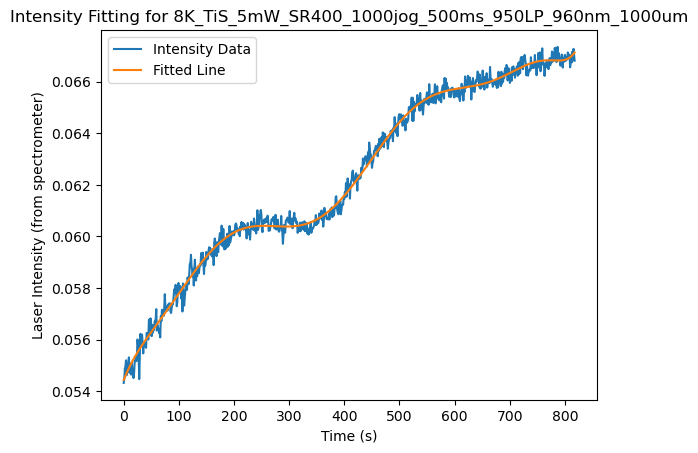

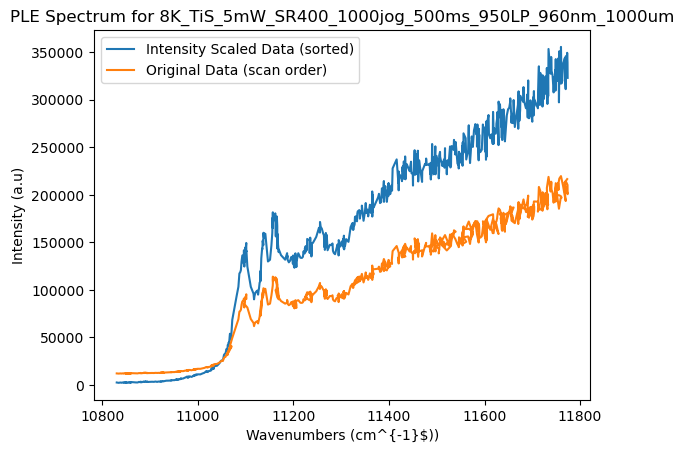

Processed and saved: 8K_TiS_5mW_SR400_1000jog_500ms_950LP_960nm_1000um


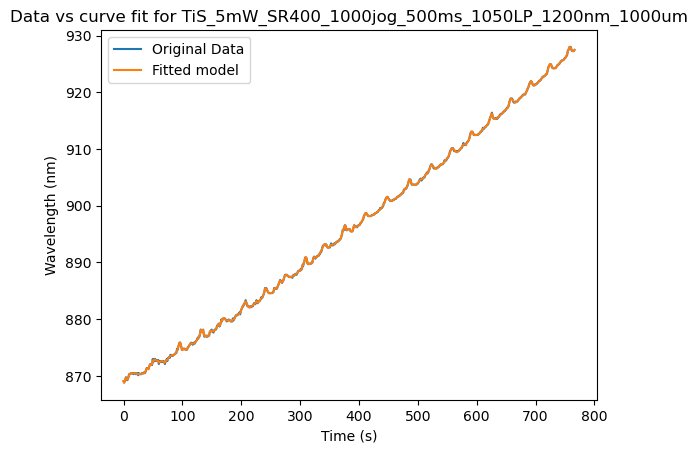

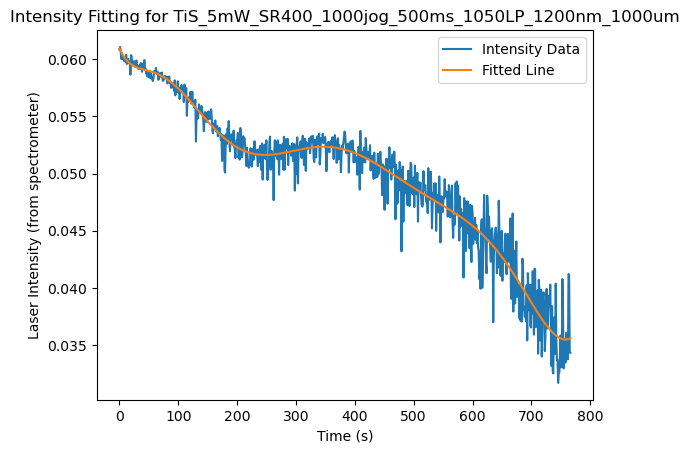

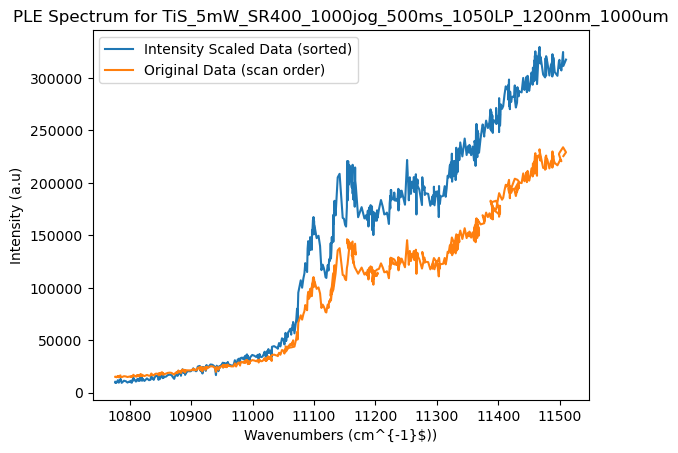

Processed and saved: TiS_5mW_SR400_1000jog_500ms_1050LP_1200nm_1000um


In [367]:
# Process each file
PLE_data = {}
for file_name in data_files:
    file_path = os.path.join(data_directory, file_name)
    t, fitted_wavelength, fitted_intensity, scaled_pmt, pmt, scaling_factor,sorted_wavelength,sorted_scaled_pmt,sorted_wavenumbers = process_data(file_path)

    # Save the processed data into the subfolder
    output_file = os.path.join(subfolder, f"{file_name}_scaled_pmt.txt")
    np.savetxt(output_file, np.column_stack((sorted_wavenumbers, sorted_scaled_pmt)), header="Fitted_Wavenumbers Scaled_PMT_Data")

    # Store data in PLE_data dictionary
    PLE_data[file_name] = {
        't': t,
        'fitted_wavelength': fitted_wavelength,
        'fitted_intensity': fitted_intensity,
        'scaled_pmt': scaled_pmt,
        'pmt': pmt,
        'scaling_factor': scaling_factor
    }

    print(f"Processed and saved: {file_name}")